In [1]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
import struct
import pickle

In [2]:
def get_features(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
def plot_image(image):
    plt.imshow(image.reshape((28,28)), cmap="gray")
    
features = get_features("train_features.gz").reshape((60000, 784))
features = features / 255
features = features.astype(np.float32)
test = get_features("test_features.gz").reshape((10000, 784))
test = test.astype(np.float32)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(0 - x))

def relu(x):
    return np.maximum(x,0)

def d_relu(x):
    return np.where(x > 0, np.full(np.shape(x), 1), np.full(np.shape(x), 0))

def squared_loss(y, x):
    return (y - x) ** 2 / 2

def d_squared_loss(y, x):
    return - (y - x)

def cross_entropy_loss(x,y):
    e = 0.0000001
    return -x*np.log(y+e) - (1-x)*np.log(e+1-y)

def d_cross_entropy_loss(x,y):
    return ((1-x)/(1-y)) - (x/y)

In [26]:
def run(xs, w_1, w_2, b_1, b_2, no_training=False):
    """ Performs automatic differntiation for the required network.
    
    :param xs: the matrix of features
    :param w1, w2, b1, b2: the matrices and vectors for the pairs of weights and biases
    :return:
        the matrix representing the loss for each value in xs
        the matrices representing the total derivative of the error function for each
        value in xs for w1, w2, b1 and b2
        the matrix representing the error for each value in xs """
    N = xs.shape[1]
    D = xs.shape[0]
    f1 = w_1 @ xs
    f2 = (b_1 + f1.T).T
    f3 = relu(f2)
    f4 = w_2 @ f3
    f5 = (b_2 + f4.T).T
    f6 = sigmoid(f5)
    f7 = cross_entropy_loss(xs, f6)
    f8 = np.sum(f7, axis=0)
    f9 = np.sum(f8)
    f10 = f9 / N
    if no_training:
        return (f6, f10)
    t10 = 1
    t9 = 1 / N
    t8 = np.full((N), 1 / N)
    t7 = np.full((D, N), 1 / N)
    t6 = d_cross_entropy_loss(xs, f6) * t7
    t5 = (f6*(1-f6)) * t6
    t4 = t5
    tb2 = np.sum(t5, axis=1)

    t3 = w_2.T @ t4
    tw2 = (f3 @ t4.T).T

    t2 = d_relu(f2) * t3

    t1 = t2
    tb1 = np.sum(t2, axis=1)
    tw1 = t1 @ xs.T
    return f6, tw1, tw2, tb1, tb2, f10

In [5]:
def adam(weight, grad, k, m_prev, v_prev, b1=0.9, b2=0.999, l=0.0000000001, rate=0.05):
    """ Performs ADAM optimisaton.
    
    :param weight: the list of weights to optimise
    :param grad: the gradient for the error function at the weights
    :param k: the round of optimisation
    :param m_prev, v_prev: the ADAM parameters at the previous round
    :return: the next round of optimisation, the ADAM parameters for the round
    
    """
    m = b1 * m_prev + (1 - b1)*grad
    v = b2 * v_prev + (1 - b2)*(grad ** 2)
    
    m_hat = m / (1 - (b1 ** k))
    v_hat = v / (1 - (b2 ** k))
    weight -= (rate / (np.sqrt(v_hat) + l))*m_hat
    return (k+1, m, v)

In [ ]:
# # Train

# def create_weight(shape):
#     stdv = 1. / np.sqrt(shape[-1])
#     return np.random.uniform(-stdv, stdv, shape).astype(np.float32)

# w1 = create_weight((30, 784))
# w2 = create_weight((784, 30))
# b1 = create_weight((30,))
# b2 = create_weight((784,))

# past_epochs = []
# past_loss_values = []

# epochs = 100
# previous_runnings = [[1,0,0] for i in range(4)]
# weights = [w1,w2,b1,b2]

# for i in range(epochs):
#     res, grad_w1, grad_w2, grad_b1, grad_b2, loss = run(features.T, w1, w2, b1, b2)
#     grads = [grad_w1, grad_w2, grad_b1, grad_b2]
#     for (j, (weight, previous_running, grad)) in enumerate(zip(weights, previous_runnings, grads)):
#         k, m, v = previous_running
#         previous_runnings[j] = adam(weight, grad, k, m, v)
#     #pickle.dump(weights, open("weight_square.p", "wb"))
#     past_epochs.append(i)
#     past_loss_values.append(loss)
#     print(i, loss)

In [31]:
# Plot slices

S = 10
w1, w2, b1, b2 = pickle.load(open("weight_cross.p", "rb"))
u1 = np.random.normal(0, 1, w1.shape)
u2 = np.random.normal(0, 1, w1.shape)
values = np.zeros((S, S))


for i in range(0, S):
    z1 = i / S
    for j in range(0, S):
        z2 = j / S
        _, l = run(features.T, w1 + z1 * u1 + z2 * u2, w2, b1, b2, no_training=True)
        values[i][j] = l
    print("At {} of {}.".format(i + 1, S))        
# fig, ax = plt.subplots() 
# plt.plot(values)
# plt.show()

At 1 of 10.
At 2 of 10.
At 3 of 10.
At 4 of 10.
At 5 of 10.
At 6 of 10.
At 7 of 10.
At 8 of 10.
At 9 of 10.
At 10 of 10.


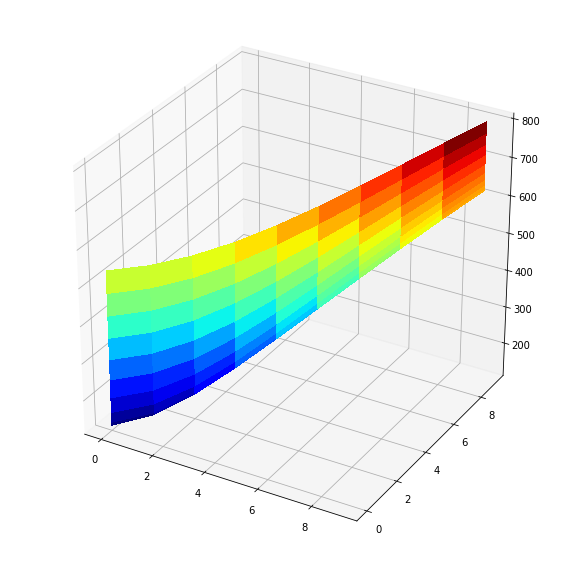

In [32]:
from mpl_toolkits import mplot3d
from matplotlib import cm
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(range(0,S), range(0,S), values, rstride=1, cstride=1,linewidth=10, antialiased=False, cmap=cm.jet)
plt.savefig("error_plot_1_cross_v2.png")

<Figure size 432x288 with 0 Axes>